In [167]:
# For Sam

In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

loading the dataset

In [169]:
dataset = pd.read_csv("Train.csv")
finaltest = pd.read_csv("Test.csv")
riders = pd.read_csv('Riders.csv')

Checking it out

In [274]:
dataset.head(2)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993


In [275]:
riders.head(2)

,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings
0,Rider_Id_396,2946,2298,14.0,1159
1,Rider_Id_479,360,951,13.5,176


In [276]:
finaltest.head(2)

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,...,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,...,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868


In [277]:
set(dataset.columns) - set(finaltest.columns)

{'Arrival at Destination - Day of Month',
 'Arrival at Destination - Time',
 'Arrival at Destination - Weekday (Mo = 1)',
 'Time from Pickup to Arrival'}

we must drop the above before moving on

are the columns in the final that are not on training?

In [278]:
set(finaltest.columns) - set(dataset.columns)

set()

The placement time of the order is irrelevant to the target. The main concern of the problem statement is the period between pickup and arrival. When the order was placed, has no bearing whatsoever in effect to that period. So, we are going to drop everything concerning placement. 

Furthermore, 'Confirmation' columns, with the same argument, must be dropped.

In [279]:
placement = [col for col in dataset.columns if ((col[:len('Placement')] == 'Placement') or (col[:len('Confirmation')] == 'Confirmation')) ]

In [280]:
placement

['Placement - Day of Month',
 'Placement - Weekday (Mo = 1)',
 'Placement - Time',
 'Confirmation - Day of Month',
 'Confirmation - Weekday (Mo = 1)',
 'Confirmation - Time']

In [281]:
xdata = dataset.drop(columns=['Time from Pickup to Arrival', 'User Id', 'Order No', 
'Arrival at Destination - Day of Month',
'Arrival at Destination - Time',
'Arrival at Destination - Weekday (Mo = 1)'] + placement)
X = xdata.copy() # I want to run this column everytime I want to restart after changes
X = X.merge(riders, how='left', on=['Rider Id']).drop(columns=['Rider Id'])

f_testx = finaltest.merge(riders, how='left', on=['Rider Id']).drop(columns=['User Id', 'Order No', 'Rider Id'] + placement)

In [282]:
y = dataset['Time from Pickup to Arrival'] # The target

Confirm columns if columns on train are those on test

In [283]:
set(f_testx.columns) == set(X.columns)

True

We Split

In [284]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now things are about to get ugly

In [285]:
### START FUNCTION
def cleaner(input_df, nullthreshold=0.9, correlation_thresh=0.95, day_of_month_cols=[], day_of_week_cols=[]):
    input_dfc = input_df.copy()
    

    #########################################################################################
    # The Code below drops columns that have null values exceeding threshold and Columns that have ONLY one value
    for col in input_df.columns:
        if (sum(input_df[col].isnull())/len(input_df[col]) > nullthreshold) or (len(input_df[col].unique()) == 1):
            input_dfc.drop(columns=[col], inplace=True) 
            
    #########################################################################################

    #########################################################################################
    #This code converts time given by am and pm into seconds then applies cosine and sine
    def time_to_seconds(input_df):
        input_dfc = input_df.copy()

        from datetime import datetime

        for time_col in [col for col in input_df.columns if 'Time' in [col[-4:]]]:

            input_dfc[time_col + '_sin(seconds)'] = \
            input_df[time_col].apply(lambda time: np.sin(
                (datetime.strptime(time, '%I:%M:%S %p') - datetime(1900,1,1)).total_seconds() \
                * (2.*np.pi/86400) )) # there are 86400 seconds in a day

            input_dfc[time_col + '_cos(seconds)'] = \
            input_df[time_col].apply(lambda time: np.cos(
                (datetime.strptime(time, '%I:%M:%S %p') - datetime(1900,1,1)).total_seconds() \
                * (2.*np.pi/86400) ))

            input_dfc.drop(columns=[time_col], inplace=True)

        return input_dfc

    input_dfc2 = time_to_seconds(input_dfc)
    #########################################################################################
    
    #########################################################################################
    # This code encodes ['Platform Type', 'Personal or Business']
    
    def one_encoder(input_df, columns):
    
        return pd.get_dummies(input_df, drop_first=True, columns=columns, dtype=float)

    
    input_dfc2 = one_encoder(input_dfc2, ['Platform Type', 'Personal or Business'])
    #########################################################################################
    def cyclic_days(input_df, month_days_cols, weekdays_cols):
        input_dfc = input_df.copy()


        for mday_col in month_days_cols:
            if mday_col in input_dfc.columns:

                input_dfc[mday_col + '_sin(day)'] = input_df[mday_col].apply(lambda day: np.sin(\
                day * (2.*np.pi/31))\
                    )

                input_dfc[mday_col + '_cos(day)'] = input_df[mday_col].apply(lambda day: np.cos(\
                day * (2.*np.pi/31))\
                    )

                input_dfc.drop(mday_col, inplace=True, axis=1)


        for wday_col in weekdays_cols:
            if wday_col in input_dfc.columns:

                input_dfc[wday_col + '_sin(day)'] = input_df[wday_col].apply(lambda day: np.sin(\
                day * (2.*np.pi/7))\
                    )

                input_dfc[wday_col + '_cos(day)'] = input_df[wday_col].apply(lambda day: np.cos(\
                day * (2.*np.pi/7))\
                    )

                input_dfc.drop(wday_col, inplace=True, axis=1)
            else:
                continue

        return input_dfc
    
    input_dfc2 = cyclic_days(input_dfc2, day_of_month_cols, day_of_week_cols)     
    #########################################################################################
    # This code will remove one of a pair of variables that are 95% correlated
    def correlation_drop(df, thresh):
        while True:
            corr_matrix = df.corr(method = "spearman").abs()
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
            to_drop = [column for column in upper.columns if any(upper[column] > thresh)]
            if len(to_drop) == 0:
                break
            else:
                df = df.drop(to_drop, axis = 1)
            
        return df
    
    input_dfc2 = correlation_drop(input_dfc2, correlation_thresh)
    #########################################################################################

    print(f"Total of {len([x for x in input_df.columns if x not in input_dfc2])} original columns dropped \n")  
    print(f"Total of {len([x for x in input_dfc2.columns if x not in input_df])} new CLEAN columns formed \n")
    print(f"Dataframe now has {len(input_dfc2.columns)} from {len(input_df.columns)} input columns")
    #print([x for x in input_df.columns if x not in input_dfc2])

    return input_dfc2

### END FUNCTION

Now we apply our ultimate cleaner

In [286]:
day_of_month_cols = [x for x in X.columns if x[-5:] == 'Month']
day_of_week_cols = [x for x in X.columns if x[-(len('(Mo = 1)')):] == '(Mo = 1)']
X_train = cleaner(X_train, day_of_month_cols=day_of_month_cols, day_of_week_cols=day_of_week_cols)

Total of 10 original columns dropped 

Total of 10 new CLEAN columns formed 

Dataframe now has 20 from 20 input columns


In [287]:
X_test = cleaner(X_test, day_of_month_cols=day_of_month_cols, day_of_week_cols=day_of_week_cols)

Total of 10 original columns dropped 

Total of 10 new CLEAN columns formed 

Dataframe now has 20 from 20 input columns


In [288]:
X1 = cleaner(X, day_of_month_cols=day_of_month_cols, day_of_week_cols=day_of_week_cols) # When we want to create a cross validation model

Total of 10 original columns dropped 

Total of 10 new CLEAN columns formed 

Dataframe now has 20 from 20 input columns


We must also apply it on our finial test: 

In [289]:
F_test = cleaner(f_testx, day_of_month_cols=day_of_month_cols, day_of_week_cols=day_of_week_cols)

Total of 10 original columns dropped 

Total of 10 new CLEAN columns formed 

Dataframe now has 20 from 20 input columns


In [290]:
X1.head(2)

,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings,Arrival at Pickup - Time_sin(seconds),Arrival at Pickup - Time_cos(seconds),Platform Type_2,Platform Type_3,Platform Type_4,Personal or Business_Personal,Arrival at Pickup - Day of Month_sin(day),Arrival at Pickup - Day of Month_cos(day),Arrival at Pickup - Weekday (Mo = 1)_sin(day),Arrival at Pickup - Weekday (Mo = 1)_cos(day)
0,4,20.4,-1.317755,36.830370,-1.300406,36.829741,1637,1309,13.8,549,0.481817,-0.876272,0.0,1.0,0.0,0.0,0.968077,-0.250653,-0.974928,-0.222521
1,16,26.4,-1.351453,36.899315,-1.295004,36.814358,396,339,13.6,69,0.085562,-0.996333,0.0,1.0,0.0,1.0,0.651372,-0.758758,-0.974928,-0.222521


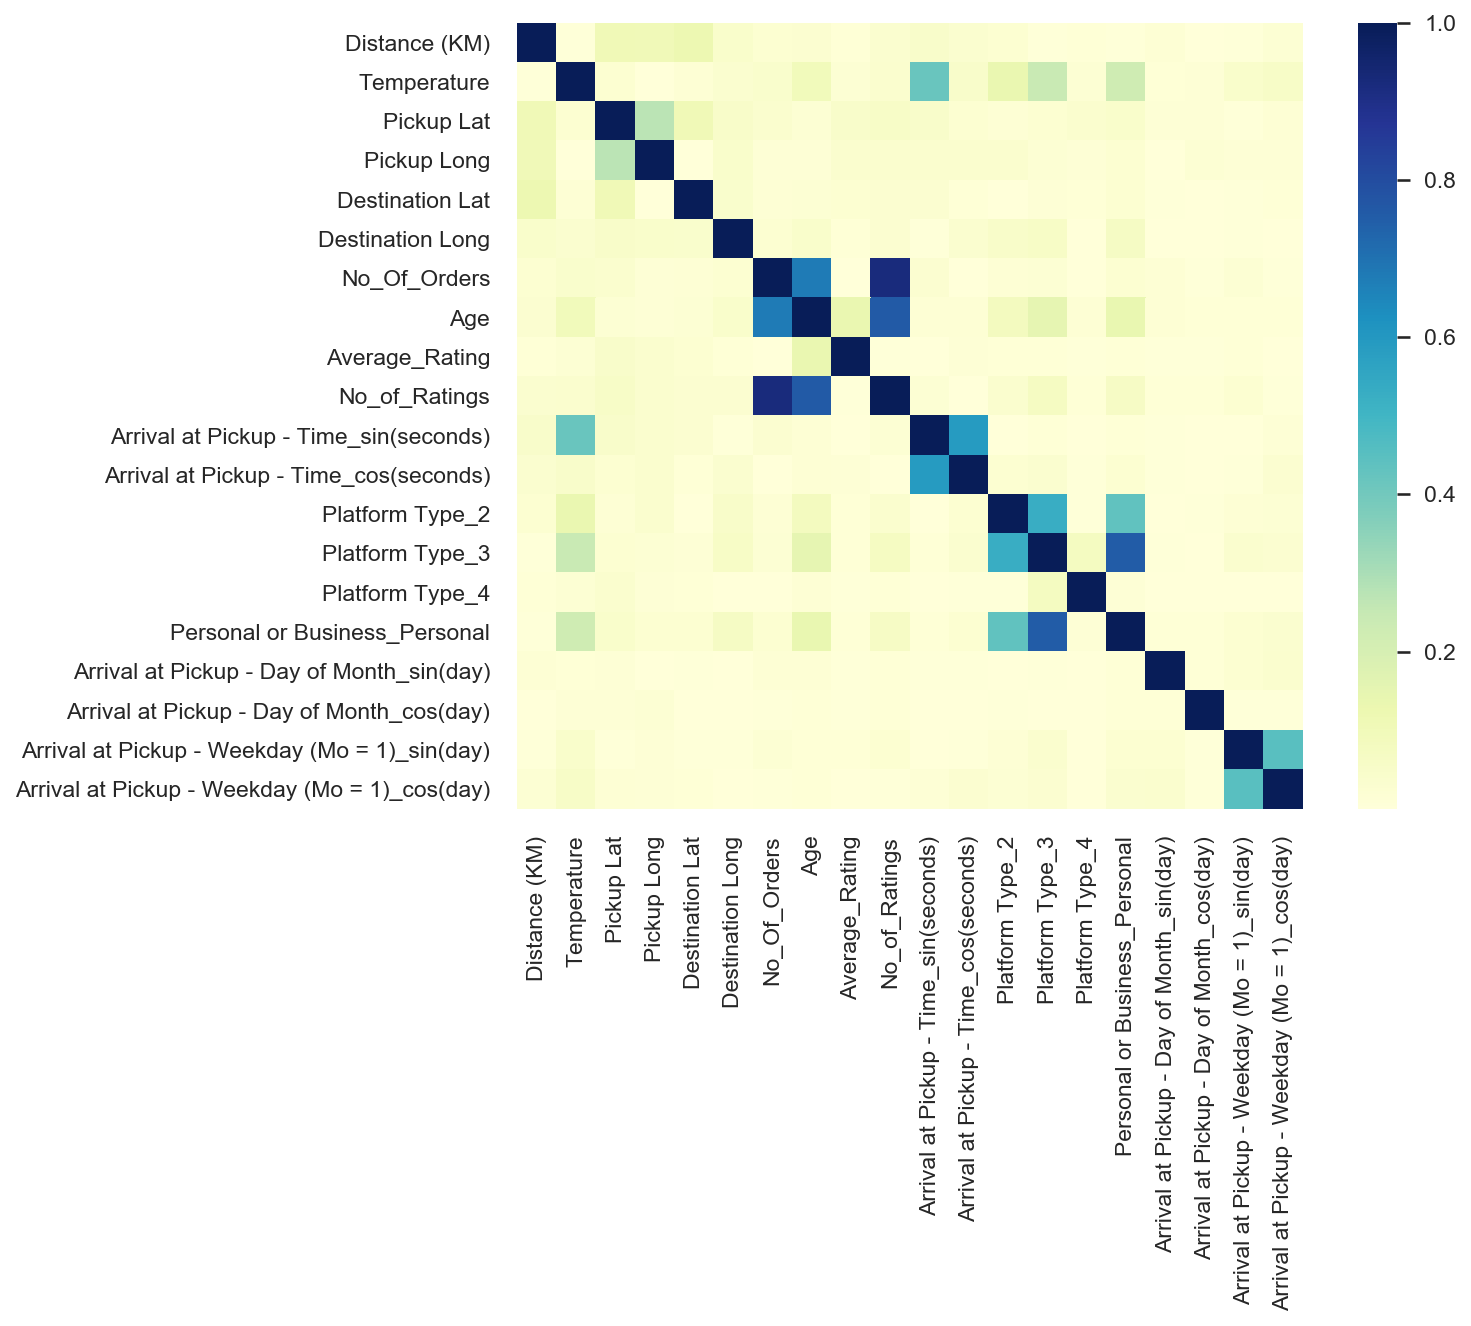

In [295]:
corr_matrix = X_train.corr(method = "spearman").abs()
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()


In [309]:
p1 = 0
for i in range(len(X1['Platform Type_2'])):
    if (X1['Platform Type_2'][i] == X1['Platform Type_3'][i]) == (X1['Platform Type_4'][i] == 0):
        p1 += 1

p2 = sum(X1['Platform Type_2'] == 1)
p3 = sum(X1['Platform Type_3'] == 1)
p4 = sum(X1['Platform Type_4'] == 1)

print('Platform Type_1: ', p1)
print('Platform Type_2: ', sum(X1['Platform Type_2'] == 1))
print('Platform Type_3: ', sum(X1['Platform Type_3'] == 1))
print('Platform Type_4: ', sum(X1['Platform Type_4'] == 1))


print('\n')

print('propotions')
print('total = ', sum([p1,p2,p3,p4]))
for value in [p1,p2,p3,p4]:
    print(round(value * 100/sum([p1,p2,p3,p4]), 2))
     

Platform Type_1:  2147
Platform Type_2:  980
Platform Type_3:  18054
Platform Type_4:  20


propotions
total =  21201
10.13
4.62
85.16
0.09


In [297]:
personal = sum(X1['Personal or Business_Personal'] == 1)
business = sum(X1['Personal or Business_Personal'] != 1)
print('personal: ', personal, '\nbusiness: ', business)

personal:  3817 
business:  17384


In [312]:
data = pd.concat([X1, y], axis=1)
data.columns

Index(['Distance (KM)', 'Temperature', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'No_Of_Orders', 'Age',
       'Average_Rating', 'No_of_Ratings',
       'Arrival at Pickup - Time_sin(seconds)',
       'Arrival at Pickup - Time_cos(seconds)', 'Platform Type_2',
       'Platform Type_3', 'Platform Type_4', 'Personal or Business_Personal',
       'Arrival at Pickup - Day of Month_sin(day)',
       'Arrival at Pickup - Day of Month_cos(day)',
       'Arrival at Pickup - Weekday (Mo = 1)_sin(day)',
       'Arrival at Pickup - Weekday (Mo = 1)_cos(day)',
       'Time from Pickup to Arrival'],
      dtype='object')

In [327]:
data[['Temperature']].head(10)

,Temperature
0,20.4
1,26.4
2,NaN
3,19.2
4,15.4
5,27.2
6,20.3
7,28.7
8,NaN
9,24.6


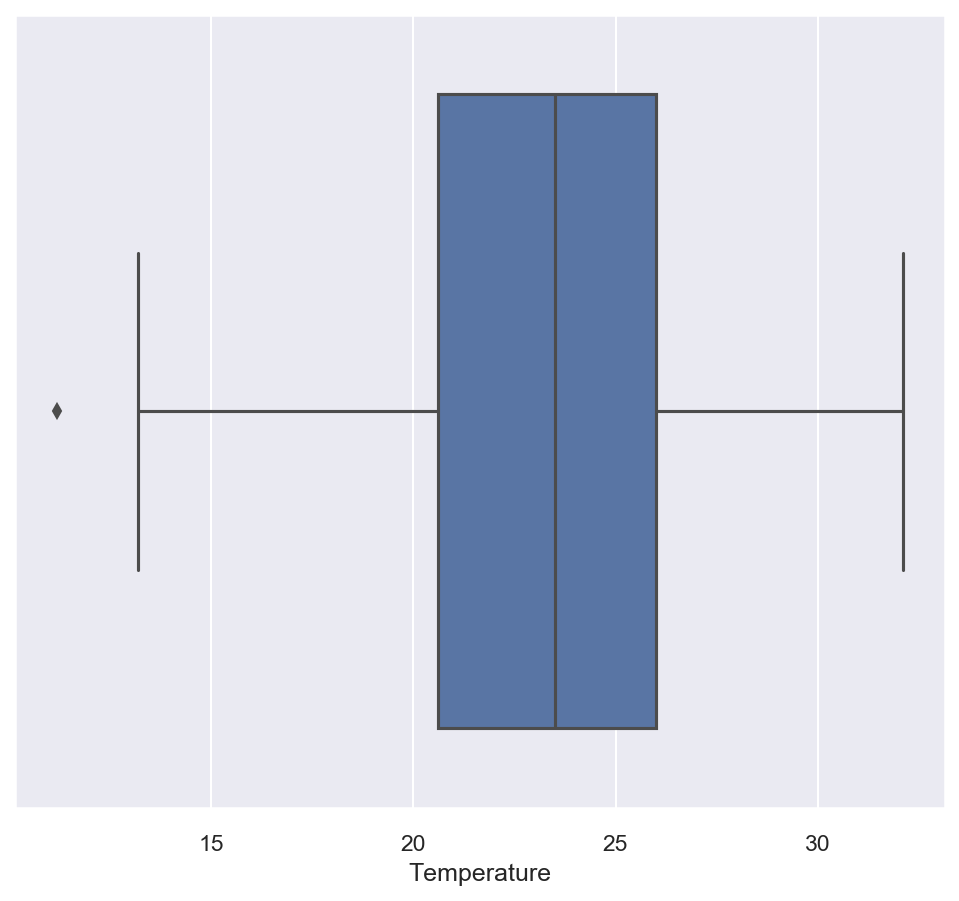

In [318]:
sns.boxplot(X1['Temperature'])

In [319]:
print('mean: ', data['Temperature'].mean())
print('median: ', data['Temperature'].median())

mean:  23.25888921888938
median:  23.5


In [329]:
data['Temperature'].fillna(data['Temperature'].median(), inplace=True)

In [339]:
corrs = data.corr()['Time from Pickup to Arrival'].sort_values(ascending=False)

from scipy.stats import pearsonr

# Build a dictionary of correlation coefficients and p-values
dict_cp = {}

column_titles = [col for col in corrs.index if col!= 'Time from Pickup to Arrival']
for col in column_titles:
    p_val = round(pearsonr(data[col], data['Time from Pickup to Arrival'])[1],6)
    dict_cp[col] = {'Correlation_Coefficient':corrs[col],
                    'P_Value':p_val}

df_cp = pd.DataFrame(dict_cp).T
df_cp_sorted = df_cp.sort_values('P_Value')
df_cp_sorted 

,Correlation_Coefficient,P_Value
Distance (KM),0.580608,0.000000
Average_Rating,-0.042559,0.000000
No_Of_Orders,-0.041608,0.000000
Pickup Lat,-0.053823,0.000000
Destination Lat,-0.061872,0.000000
Pickup Long,0.060285,0.000000
Destination Long,0.070425,0.000000
Arrival at Pickup - Weekday (Mo = 1)_cos(day),-0.025897,0.000162
Arrival at Pickup - Time_sin(seconds),-0.023330,0.000681
Arrival at Pickup - Day of Month_sin(day),0.021230,0.001992


In [340]:
to_drop = df_cp_sorted[df_cp_sorted['P_Value'] > 0.1].index
X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)
F_test.drop(columns=to_drop, inplace=True)
X1.drop(columns=to_drop, inplace=True)

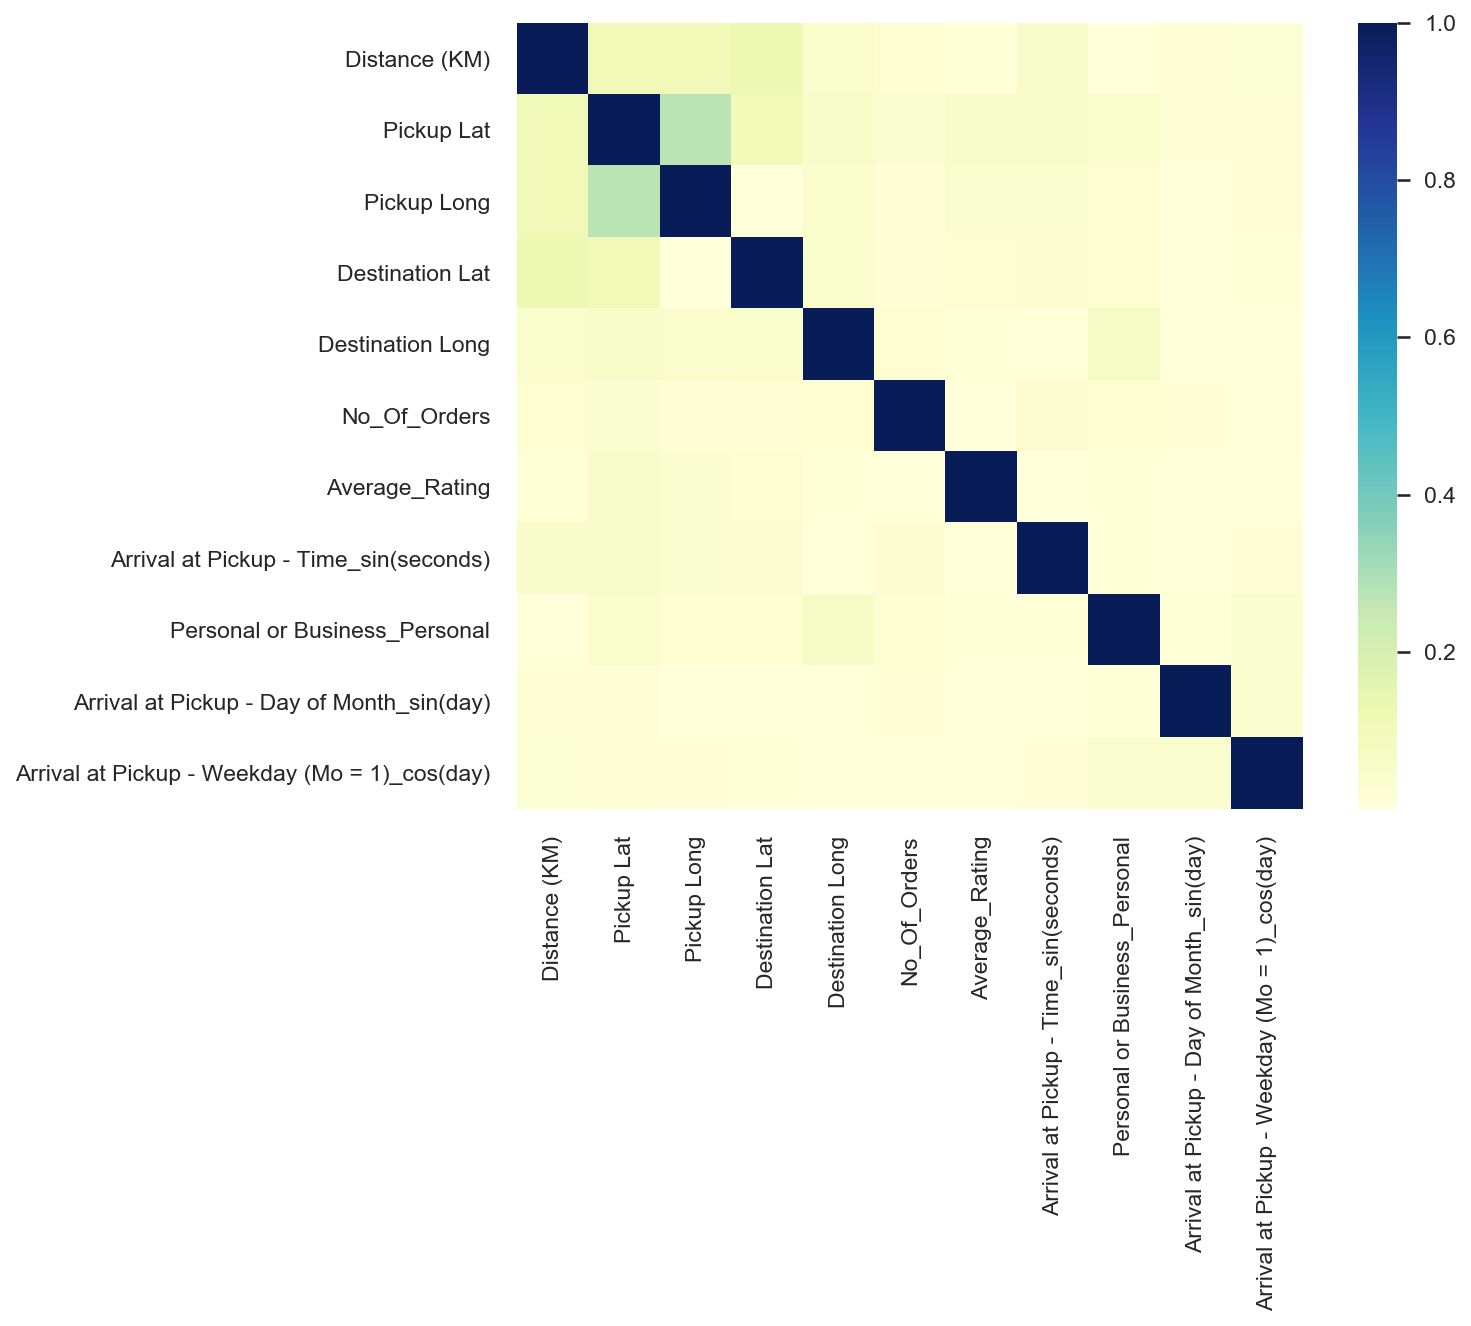

In [341]:
corr_matrix = X_train.corr(method = "spearman").abs()
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()


Our data is ready

We will standardize the columns which have a max absolute value that is greater than 1

In [186]:
# 'We use this code to apply standard scaler, and still keep our data as a dataframe instead of an array'

# from sklearn_pandas import DataFrameMapper
# from sklearn.preprocessing import StandardScaler

# mapper = DataFrameMapper([(X_train.columns, StandardScaler())])
# scaled_features = mapper.fit_transform(X_train.copy(), 4)
# scaled_features_df = pd.DataFrame(scaled_features, index=X_train.index, columns=X_train.columns)
# scaled_features_df.head(2)

In [355]:
X1.head(10)

,Distance (KM),Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Average_Rating,Arrival at Pickup - Time_sin(seconds),Personal or Business_Personal,Arrival at Pickup - Day of Month_sin(day),Arrival at Pickup - Weekday (Mo = 1)_cos(day)
0,4,-1.317755,36.830370,-1.300406,36.829741,1637,13.8,0.481817,0.0,0.968077,-0.222521
1,16,-1.351453,36.899315,-1.295004,36.814358,396,13.6,0.085562,1.0,0.651372,-0.222521
2,3,-1.308284,36.843419,-1.300921,36.828195,1023,12.5,-0.214593,0.0,-0.201299,-0.222521
3,9,-1.281301,36.832396,-1.257147,36.795063,886,14.5,0.580940,0.0,0.101168,-0.222521
4,9,-1.266597,36.792118,-1.295041,36.809817,2311,14.1,0.485255,1.0,0.485302,0.623490
5,9,-1.302583,36.767081,-1.257309,36.806008,3288,14.2,-0.770513,0.0,0.299363,-0.222521
6,5,-1.279395,36.825364,-1.276574,36.851365,288,13.7,0.525472,0.0,0.968077,-0.222521
7,3,-1.252796,36.800313,-1.255189,36.782203,4036,14.4,-0.579103,0.0,0.790776,0.623490
8,9,-1.255189,36.782203,-1.300255,36.825657,162,15.0,-0.058000,0.0,-0.201299,-0.222521
9,14,-1.225322,36.808550,-1.215601,36.891686,1062,13.2,-0.992905,0.0,-0.998717,-0.222521


In [356]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline
polinomial_features = PolynomialFeatures()
# Construct the pipeline with a standard scaler and a small neural network
models = [Lasso(alpha=0.1), Ridge(), LinearRegression()]
for mod in models:
    estimators = []
    estimators.append(('imputer', SimpleImputer(strategy='median')))
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('plf', polinomial_features))
    estimators.append(('mod', mod))
    model = Pipeline(estimators)

    # To begin, let's use only these two features to predict 'cnt' (bicycle count)

    # We'll use 5-fold cross validation. That is, a random 80% of the data will be used
    # to train the model, and the prediction score will be computed on the remaining 20%.
    # This process is repeated five times such that the training sets in each "fold"
    # are mutually orthogonal.
    from sklearn.model_selection import KFold
    from sklearn.model_selection import cross_val_score
    kfold = KFold(n_splits=5)

    results = cross_val_score(model, X1, y, cv=kfold, scoring='neg_mean_squared_error')
    print(mod)
    print ('CV Scoring Result: mean=',np.sqrt(abs(np.mean(results))),'std=',np.std(results))
    print('\n')

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
CV Scoring Result: mean= 785.5800626271457 std= 32512.784016909787


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
CV Scoring Result: mean= 785.609033100734 std= 32517.219514157918


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
CV Scoring Result: mean= 785.6088725649045 std= 32518.07093663242




In [199]:
np.sqrt(abs(results))

array([829.46408103, 810.77419923, 795.65175283, 773.46208752,
       774.0349083 ])

In [299]:
data.head(1)

,Distance (KM),Temperature,Pickup Lat,Pickup Long,Destination Lat,Destination Long,No_Of_Orders,Age,Average_Rating,No_of_Ratings,...,Arrival at Pickup - Time_cos(seconds),Platform Type_2,Platform Type_3,Platform Type_4,Personal or Business_Personal,Arrival at Pickup - Day of Month_sin(day),Arrival at Pickup - Day of Month_cos(day),Arrival at Pickup - Weekday (Mo = 1)_sin(day),Arrival at Pickup - Weekday (Mo = 1)_cos(day),Time from Pickup to Arrival
0,4,20.4,-1.317755,36.830370,-1.300406,36.829741,1637,1309,13.8,549,...,-0.876272,0.0,1.0,0.0,0.0,0.968077,-0.250653,-0.974928,-0.222521,745
1,16,26.4,-1.351453,36.899315,-1.295004,36.814358,396,339,13.6,69,...,-0.996333,0.0,1.0,0.0,1.0,0.651372,-0.758758,-0.974928,-0.222521,1993


In [301]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 21 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Distance (KM)                                  21201 non-null  int64  
 1   Temperature                                    21201 non-null  float64
 2   Pickup Lat                                     21201 non-null  float64
 3   Pickup Long                                    21201 non-null  float64
 4   Destination Lat                                21201 non-null  float64
 5   Destination Long                               21201 non-null  float64
 6   No_Of_Orders                                   21201 non-null  int64  
 7   Age                                            21201 non-null  int64  
 8   Average_Rating                                 21201 non-null  float64
 9   No_of_Ratings                                  212

In [302]:
# Calculate correlations between predictor variables and the response variable
corrs = df_dummies.corr()['Time from Pickup to Arrival'].sort_values(ascending=False)

from scipy.stats import pearsonr

# Build a dictionary of correlation coefficients and p-values
dict_cp = {}

column_titles = [col for col in corrs.index if col!= 'Time from Pickup to Arrival']
for col in column_titles:
    p_val = round(pearsonr(df_dummies[col], df_dummies['Time from Pickup to Arrival'])[1],6)
    dict_cp[col] = {'Correlation_Coefficient':corrs[col],
                    'P_Value':p_val}

df_cp = pd.DataFrame(dict_cp).T
df_cp_sorted = df_cp.sort_values('P_Value')
df_cp_sorted



,Correlation_Coefficient,P_Value
Distance (KM),0.580608,0.000000
Average_Rating,-0.042559,0.000000
No_Of_Orders,-0.041608,0.000000
Pickup Lat,-0.053823,0.000000
Destination Lat,-0.061872,0.000000
Pickup Long,0.060285,0.000000
Destination Long,0.070425,0.000000
Arrival at Pickup - Weekday (Mo = 1)_cos(day),-0.025897,0.000162
Arrival at Pickup - Time_sin(seconds),-0.023330,0.000681
Arrival at Pickup - Day of Month_sin(day),0.021230,0.001992


In [190]:
# corr_matrix = scaled_features_df.corr(method = "spearman").abs()
# sns.set(font_scale = 1.0)
# f, ax = plt.subplots(figsize=(11, 9))
# sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
# f.tight_layout()


In [191]:
# sfs.fit(scaled_features_df, y_train)
# sfs.k_feature_names_ 
# don't mind this code
# sfs.scorer(LinearRegression(), scaled_features_df, y_train)

In [192]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

In [193]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [194]:
models = [LinearRegression()]
polinomial_features = PolynomialFeatures(2)


for model in models:
    # numeric_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='median')),
    # ('scaler', StandardScaler())])
    
    # preprocessor = ColumnTransformer(
    # transformers=[
    #     ('num', numeric_transformer, cols_to_standard)])
    
    steps = [('imputer', SimpleImputer(strategy='mean')), ('polf', polinomial_features), 
          ('Scaler', StandardScaler()),
          ('model', model)]
    
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(model)
    print("model r2 score: %.3f" % pipe.score(X_test, y_test))
    print(f"model rmse score: {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print('\n')
    

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
model r2 score: -3630571930442484736.000
model rmse score: 1849556957377.1758




TypeError: mean_squared_error() got an unexpected keyword argument 'squared'

In [195]:
sample = pd.read_csv('SampleSubmission.csv')

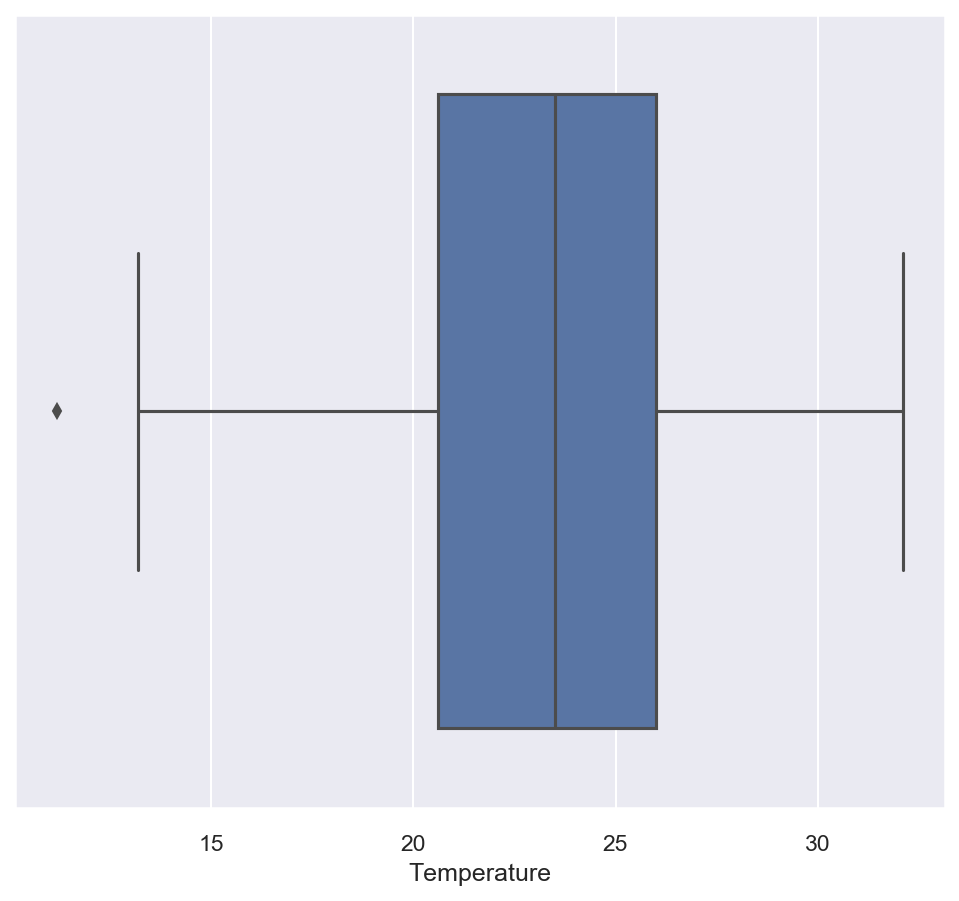

In [305]:
sns.boxplot(X1['Temperature'])

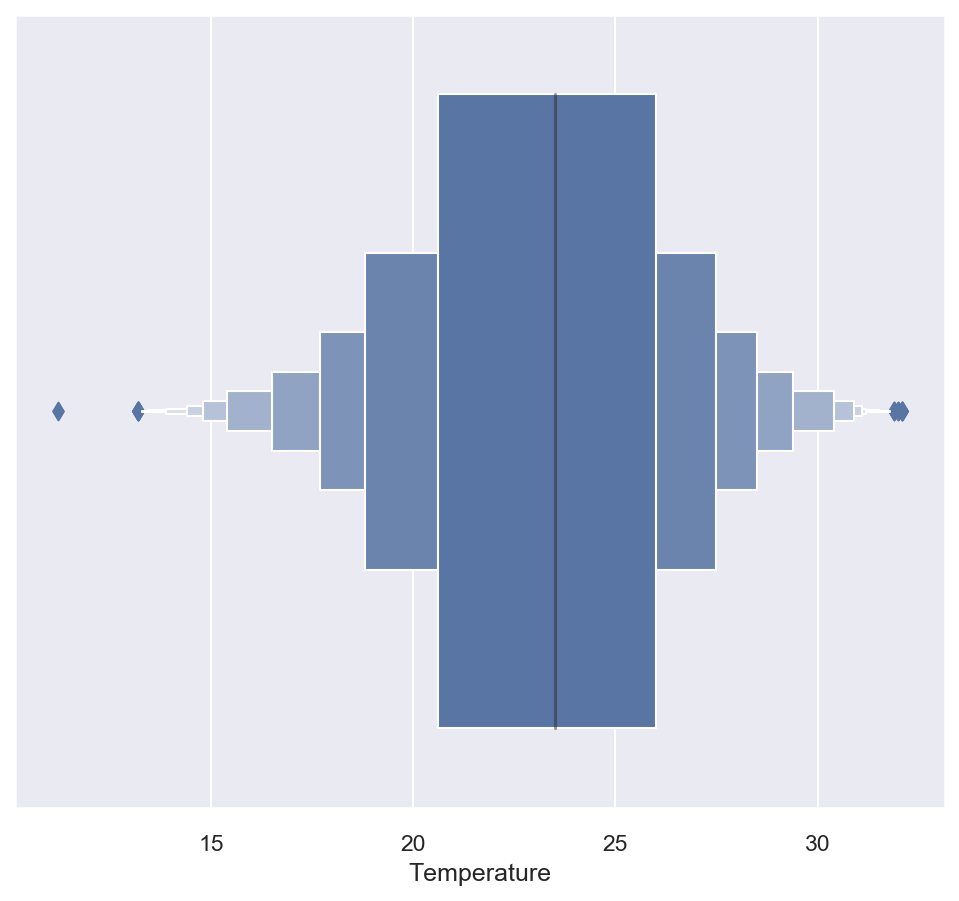

In [306]:
sns.boxenplot(X1['Temperature'])
